In [1]:
!pip install style sns
!pip install torchviz
!pip install graphviz

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd ./drive/MyDrive/project

/content/drive/MyDrive/project


In [4]:
!ls

 CamVid		   model_graph	      UNet.ipynb	    video_YOLO.mp4
 City_Dataset.py   model_graph.png    UNet_model_best.pth   video_YOLO_MSI.mp4
 cityscapes_data   __pycache__	      UNet_model.pth	    yolov5s.pt
 GRU.py		   segnet_model.pth   UNet.py		   'YOLO video and optical flow test.ipynb'
 Main.ipynb	   UNet-cityscape     video_new.mp4


In [5]:
import style
import sns
from glob import glob
import torch
import numpy as np
import pandas as pd
import os
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from UNet import UNet
from PIL import Image
from City_Dataset import City_Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [6]:
# def calculate_mean_std(dataloader):
#     channels_sum, channels_squared_sum, num_batches = 0, 0, 0

#     for data, _ in dataloader:
#         channels_sum += torch.mean(data, dim=[0,2,3])
#         channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
#         num_batches += 1

#     mean = channels_sum / num_batches
#     std = (channels_squared_sum / num_batches - mean**2)**0.5

#     return mean, std

# mean, std = calculate_mean_std(dataloader)
# print(f"Mean_train: {mean}")
# print(f"Standard Deviation_train: {std}")

In [7]:
import torch.nn.functional as F
import torch.nn as nn

class ComboLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, smooth=1e-6):
        super(ComboLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, inputs, targets):

        # Dice loss
        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)

        # Cross Entropy Loss
        ce_loss = F.binary_cross_entropy(inputs, targets)

        # Combo_loss
        combo_loss = self.alpha * dice_loss + self.beta * ce_loss

        return combo_loss

In [8]:
transformsImage = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize(mean=(0.2876, 0.3247, 0.2847), std=(0.1841, 0.1865, 0.1848)),
        # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
        transforms.RandomHorizontalFlip(p=0.5)
    ]
)

transformsLabel = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5)
    ]
)

In [9]:
def denormalize(tensor):
    mean = torch.tensor([0.2876, 0.3247, 0.2847]).view(-1, 1, 1)
    std = torch.tensor([0.1841, 0.1865, 0.1848]).view(-1, 1, 1)
    tensor = tensor * std + mean
    return torch.clamp(tensor, 0, 1)


In [10]:
def evaluate_model(model, data_loader, device, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, masks in data_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

    return total_loss / len(data_loader)

In [11]:
def visualize_prediction(image, mask, prediction):
    """
    Visualize the original image, true mask, and predicted mask side by side.
    """

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')

    transposed_image = np.transpose(mask, (1, 2, 0))
    plt.subplot(1, 3, 2)
    plt.imshow(transposed_image)
    plt.title('True Mask')

    prediction = prediction.squeeze().cpu()
    # prediction = denormalize(prediction)
    prediction = np.transpose(prediction, (1, 2, 0))

    plt.subplot(1, 3, 3)
    plt.imshow(prediction)
    plt.title('Model Prediction')

    plt.show()

In [12]:
#data load and preprocessing
# traindata = datasets.Cityscapes("./Cityscapes", split='train', mode='fine', target_type='semantic',
#                            transform=mytransformsImage, target_transform=mytransformsLabel)
# testdata = datasets.Cityscapes("./Cityscapes", split='test', mode='fine', target_type='semantic',
#                            transform=mytransformsImage, target_transform=mytransformsLabel)
# valdata = datasets.Cityscapes("./Cityscapes", split='test', mode='fine', target_type='semantic',
#                            transform=mytransformsImage, target_transform=mytransformsLabel)

# train_loader = DataLoader(traindata, batch_size=2, shuffle=True)
# test_loader = DataLoader(testdata, batch_size=2, shuffle=True)
# vaild_loader = DataLoader(valdata, batch_size=2, shuffle=True)

train_paths = glob('./cityscapes_data/train/*')
val_paths = glob('./cityscapes_data/val/*')

#batch_size
batch_size = 8

#train data
traindata = City_Dataset(train_paths, transformsImage, transformsLabel)
# val dataset
valdata = City_Dataset(val_paths, transformsImage, transformsLabel)
train_loader = DataLoader(traindata, batch_size, num_workers = 8)
vaild_loader = DataLoader(valdata, batch_size, num_workers = 8)



In [13]:
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    """Dice Loss PyTorch Implementation."""
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predicted, target):
        # Flatten the tensors to vector form
        predicted_flat = predicted.view(-1)
        target_flat = target.view(-1)

        # Calculate intersection and union
        intersection = (predicted_flat * target_flat).sum()
        union = predicted_flat.sum() + target_flat.sum()

        # Compute the Dice score
        dice_score = (2. * intersection + self.smooth) / (union + self.smooth)

        # Return Dice loss
        return 1 - dice_score


In [14]:
device = torch.device("cuda:0")
model = UNet(in_chn=3, out_chn=3, kernel_size = 3, stride=1, BN_momentum= 0.9, dropout_p = 0.1, padding = 1).to(device)
# model.load_state_dict(torch.load('UNet_model_best.pth'))
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

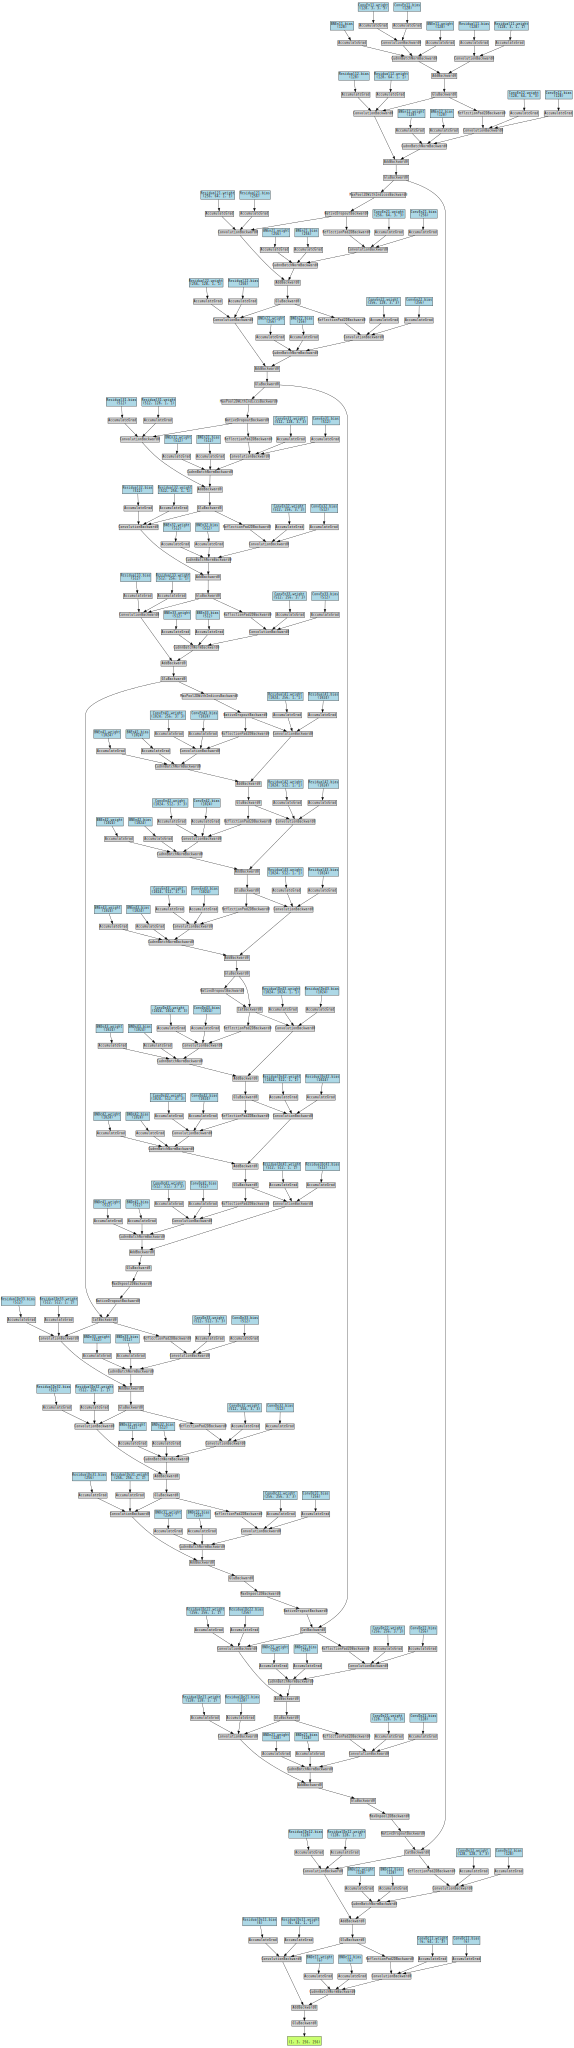

In [15]:
import torch
from torchviz import make_dot

first_batch_images, first_batch_masks = next(iter(train_loader))
first_batch_images, first_batch_masks = first_batch_images.to(device), first_batch_masks.to(device)
original_image = next(iter(traindata))
first_image = first_batch_images[0].unsqueeze(0)

y = model(first_image)

# graph visualization
dot = make_dot(y, params=dict(model.named_parameters()))

# save to img
dot.render('model_graph', format='png')

# graph plot
dot

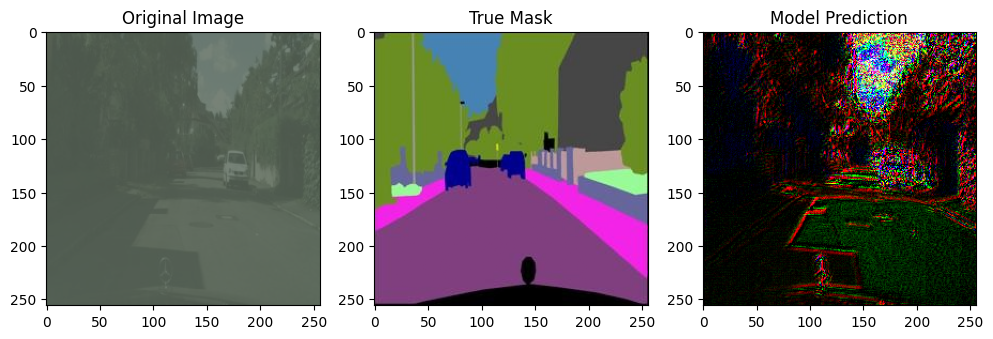

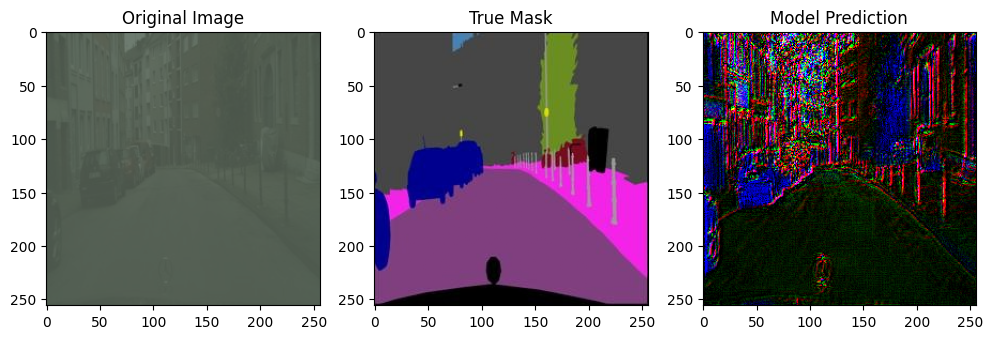

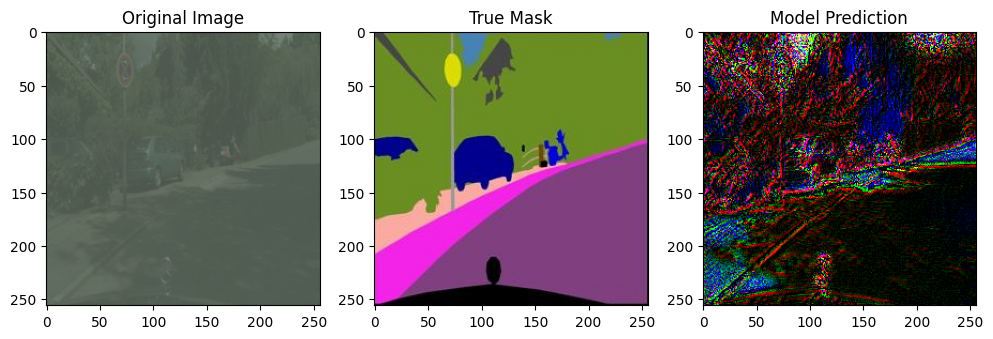

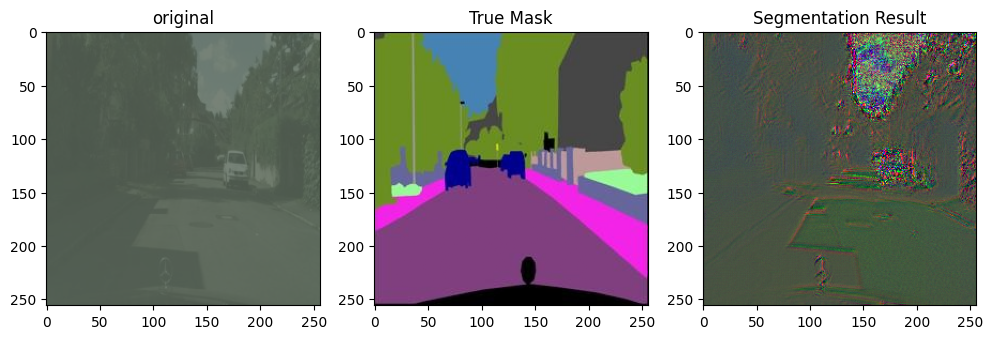

In [16]:

first_batch_images, first_batch_masks = next(iter(train_loader))
first_batch_images, first_batch_masks = first_batch_images.to(device), first_batch_masks.to(device)
original_image = next(iter(traindata))
first_image = first_batch_images[0].unsqueeze(0)
second_image = first_batch_images[1].unsqueeze(0)
third_image = first_batch_images[2].unsqueeze(0)


with torch.no_grad():
    prediction = model(first_image)
    prediction2 = model(second_image)
    prediction3 = model(third_image)


first_image = first_image.cpu().squeeze()
first_image = denormalize(first_image)
first_image_transposed = np.transpose(first_image, (1, 2, 0))

second_image = second_image.cpu().squeeze()
second_image = denormalize(second_image)
second_image_transposed = np.transpose(second_image, (1, 2, 0))

third_image = third_image.cpu().squeeze()
third_image = denormalize(third_image)
third_image_transposed = np.transpose(third_image, (1, 2, 0))

first_mask = first_batch_masks[0].squeeze(1).cpu()
second_mask = first_batch_masks[1].squeeze(1).cpu()
third_mask = first_batch_masks[2].squeeze(1).cpu()


visualize_prediction(first_image_transposed, first_mask, prediction)
visualize_prediction(second_image_transposed, second_mask, prediction2)
visualize_prediction(third_image_transposed, third_mask, prediction3)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(first_image_transposed)
plt.title('original')

plt.subplot(1, 3, 2)

first_mask_transposed = np.transpose(first_mask, (1, 2, 0))
plt.imshow(first_mask_transposed)
plt.title('True Mask')


plt.subplot(1, 3, 3)

prediction = prediction.squeeze().cpu()
prediction = denormalize(prediction)
prediction = np.transpose(prediction, (1, 2, 0))

plt.imshow(prediction)
plt.title('Segmentation Result')
plt.show()



In [ ]:
num_epochs = 100
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 3
patience_counter = 0

for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    for images, masks in tqdm(train_loader):
        optimizer.zero_grad()
        images, masks = images.to(device), masks.to(device)

        # forward
        outputs = model(images)
        # loss
        loss = criterion(outputs, masks)

        # backprob
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # update print
        # if (i+1) % 100 == 0:
        #     print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():}')



    train_losses.append(total_loss / len(train_loader))

    val_loss = evaluate_model(model, vaild_loader, device, criterion)
    val_losses.append(val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}') # Monitoring

    if epoch == 0:  # Store the first batch's images and masks
        first_batch_images, first_batch_masks = next(iter(train_loader))
        first_batch_images, first_batch_masks = first_batch_images.to(device), first_batch_masks.to(device)
        first_image = first_batch_images[0].unsqueeze(0)
        second_image = first_batch_images[1].unsqueeze(0)
        third_image = first_batch_images[2].unsqueeze(0)

        first_image_original = first_image.cpu().squeeze()
        # first_image_original = denormalize(first_image_original)
        first_image_transposed = np.transpose(first_image_original, (1, 2, 0))

        second_image_original = second_image.cpu().squeeze()
        # second_image_original = denormalize(second_image_original)
        second_image_transposed = np.transpose(second_image_original, (1, 2, 0))

        third_image_original = third_image.cpu().squeeze()
        # third_image_original = denormalize(third_image_original)
        third_image_transposed = np.transpose(third_image_original, (1, 2, 0))

        first_mask = first_batch_masks[0].squeeze(1).cpu()
        second_mask = first_batch_masks[1].squeeze(1).cpu()
        third_mask = first_batch_masks[2].squeeze(1).cpu()

    with torch.no_grad(): # Monitoring
      prediction = model(first_image)
      prediction2 = model(second_image)
      prediction3 = model(third_image)
      visualize_prediction(first_image_transposed, first_mask, prediction)
      visualize_prediction(second_image_transposed, second_mask, prediction2)
      visualize_prediction(third_image_transposed, third_mask, prediction3)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'UNet_model_best.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping worked at epoch {epoch + 1}')
        break

    # model save
    torch.save(model.state_dict(), 'UNet_model.pth')



